# Setup

In [2]:
%cd ..

C:\Users\pooya\Codes\BubbleTracking


In [3]:
%load_ext autoreload
%autoreload 2

In [42]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
import os
import numpy as np
import PIL
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

# Create Datasets

In [5]:
imgs_path = Path('./data/images/Source/')
mask_path_train = Path('./data/joined_masks/train/')
mask_path_test = Path('./data/joined_masks/test/')

In [25]:
class BubbleDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, mask_path):
        super(BubbleDataset, self).__init__()
        image_id = os.listdir(mask_path)
        ids = []
        for iid in image_id:
            path = os.path.join(mask_path, iid)
            mask = Image.open(path) 
            if np.max(mask)>0:
                ids.append(iid)
        self.image_id = ids
        self.image_path = img_path
        self.mask_path = mask_path

    def get_boxes(self, idx):
        mask, _ = self.get_mask(idx)
        array = np.array(mask)
        if array.max() == 0:
            return []

        obj_ids = np.unique(array)[1:]

        boxes = []
        for i in obj_ids:
            pos = np.where(array == i)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        return np.array(boxes)

    def get_image(self, idx):
        path = os.path.join(self.image_path, self.image_id[idx])
        image = Image.open(path)
        return image

    def get_mask(self, idx):
        path = os.path.join(self.mask_path, self.image_id[idx])
        mask = Image.open(path)
        if np.max(mask) == 0:
            return mask, np.array(mask)
        nmax = np.max(mask)
        layered = np.zeros((nmax, np.shape(mask)[0], np.shape(mask)[1]))
        for i in range(nmax):
            layered[i, :, :] = mask == (i + 1)
        return mask, layered

    def visualise(self, idx):
        img = self.get_image(idx)
        boxes = self.get_boxes(idx)
        draw = ImageDraw.Draw(img)
        for i in range(boxes.shape[0]):
            draw.rectangle(list(boxes[i, :]), outline='red', width=3)
        return img

    def __getitem__(self, idx):
        target = {}
        boxes = self.get_boxes(idx)
        _, masks = self.get_mask(idx)
        if len(boxes) == 0:
            area = torch.tensor([],dtype=torch.float)
            img = self.get_image(idx)
            img = np.array(img)
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float)
            target['labels'] = torch.ones((0, ), dtype=torch.int64)
            target['masks'] = torch.as_tensor(masks,dtype = torch.uint8)
            target['image_id'] = torch.tensor([idx])
            target['area'] = area
            target['iscrowd'] = torch.zeros((0, ), dtype=torch.int64)
        else:
            area = torch.as_tensor(
                (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                dtype=torch.float)
            usable = area>0
            _, masks = self.get_mask(idx)
            img = self.get_image(idx)
            img = np.array(img)
            target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)[usable]
            target['labels'] = torch.ones((len(usable), ), dtype=torch.int64)
            target['masks'] = torch.as_tensor(masks,dtype = torch.uint8)[usable]
            target['image_id'] = torch.tensor([idx])
            target['area'] = area[usable]
            target['iscrowd'] = torch.zeros((len(usable), ), dtype=torch.int64)

        return torch.tensor(img).permute(2, 0, 1).float(), target

    def __len__(self):
        return len(self.image_id)

    @property
    def length(self):
        return len(self)

In [26]:
dstr = BubbleDataset(imgs_path,mask_path_train)
dsval =BubbleDataset(imgs_path,mask_path_test)

In [ ]:
loader = DataLoader(dstr,
                    batch_size=2,
                    shuffle=True,
                    collate_fn=collate_fn
                   )
test_loader = DataLoader(
    dsval,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

# Create Model

In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
from utils import collate_fn
from engine import train_one_epoch, evaluate


In [14]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [55]:
num_classes = 2
model = get_model_instance_segmentation(num_classes)

# Train Model

In [57]:
device =torch.device('cuda')
model = model.to(device)

In [59]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr = 0.001, weight_decay=1e-3)
lr_sch = optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=.1)

In [60]:
epochs = 10
for epoch in range(epochs):
    train_one_epoch(model,optimizer,loader,device,epoch,12)
    lr_sch.step()
    evaluate(model,test_loader,device=device)

Epoch: [0]  [ 0/84]  eta: 0:02:43  lr: 0.000013  loss: 512.7791 (512.7791)  loss_classifier: 79.8223 (79.8223)  loss_box_reg: 3.2596 (3.2596)  loss_mask: 207.1130 (207.1130)  loss_objectness: 168.4528 (168.4528)  loss_rpn_box_reg: 54.1313 (54.1313)  time: 1.9438  data: 1.4182  max mem: 5526
Epoch: [0]  [12/84]  eta: 0:02:46  lr: 0.000157  loss: 77.4858 (167.7860)  loss_classifier: 12.6263 (20.5097)  loss_box_reg: 2.8101 (2.8415)  loss_mask: 0.2932 (52.9837)  loss_objectness: 57.4110 (66.8577)  loss_rpn_box_reg: 21.0010 (24.5935)  time: 2.3170  data: 1.7511  max mem: 5526
Epoch: [0]  [24/84]  eta: 0:02:10  lr: 0.000302  loss: 14.5566 (91.5459)  loss_classifier: 3.0179 (12.5163)  loss_box_reg: 1.3840 (2.1560)  loss_mask: 0.0000 (27.5515)  loss_objectness: 4.7889 (35.7128)  loss_rpn_box_reg: 1.9264 (13.6093)  time: 2.0678  data: 1.5169  max mem: 5526
Epoch: [0]  [36/84]  eta: 0:01:44  lr: 0.000446  loss: 5.3342 (64.3299)  loss_classifier: 2.1669 (9.5089)  loss_box_reg: 0.9112 (1.9941)  lo

Epoch: [2]  [ 0/84]  eta: 0:02:27  lr: 0.001000  loss: 19.8663 (19.8663)  loss_classifier: 7.9015 (7.9015)  loss_box_reg: 10.0325 (10.0325)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.6874 (0.6874)  loss_rpn_box_reg: 1.2450 (1.2450)  time: 1.7533  data: 1.2028  max mem: 5526
Epoch: [2]  [12/84]  eta: 0:02:31  lr: 0.001000  loss: 2.7045 (4.0728)  loss_classifier: 0.6511 (1.2022)  loss_box_reg: 0.0110 (0.7809)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.6874 (0.8249)  loss_rpn_box_reg: 1.2900 (1.2647)  time: 2.1004  data: 1.5541  max mem: 5526
Epoch: [2]  [24/84]  eta: 0:02:09  lr: 0.001000  loss: 2.7640 (3.4521)  loss_classifier: 0.6509 (0.9342)  loss_box_reg: 0.0138 (0.4159)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.6594 (0.7510)  loss_rpn_box_reg: 1.3650 (1.3510)  time: 2.1319  data: 1.5877  max mem: 5526
Epoch: [2]  [36/84]  eta: 0:01:42  lr: 0.001000  loss: 2.7983 (3.2388)  loss_classifier: 0.6435 (0.8394)  loss_box_reg: 0.0173 (0.2866)  loss_mask: 0.0000 (0.0000)  los

RuntimeError: CUDA out of memory. Tried to allocate 792.00 MiB (GPU 0; 8.00 GiB total capacity; 3.43 GiB already allocated; 186.97 MiB free; 5.67 GiB reserved in total by PyTorch)

# Evaluation

In [61]:
evaluate(model,test_loader,device=device)

creating index...
index created!


RuntimeError: CUDA out of memory. Tried to allocate 792.00 MiB (GPU 0; 8.00 GiB total capacity; 4.48 GiB already allocated; 186.97 MiB free; 5.67 GiB reserved in total by PyTorch)

# Testing

In [62]:
model = model.to('cpu')
idx = 20
img, _ = dsval[idx]
with torch.no_grad():
    preds = model([img])

In [64]:
preds

[{'boxes': tensor([[1.2083e+03, 6.3628e-02, 1.2341e+03, 2.6961e+01],
          [8.2535e+02, 3.1289e+02, 8.7916e+02, 4.2199e+02],
          [6.3797e+02, 6.3628e-02, 6.6370e+02, 2.6961e+01],
          [8.5114e+02, 9.0907e-02, 8.7687e+02, 3.8519e+01],
          [7.9929e+02, 9.0907e-02, 8.2502e+02, 3.8519e+01],
          [5.6883e+02, 7.7268e-02, 5.9456e+02, 3.2740e+01],
          [2.7694e-02, 3.1289e+02, 2.6355e+01, 4.2199e+02],
          [1.3121e+03, 6.3628e-02, 1.3378e+03, 2.6961e+01],
          [1.5398e+03, 4.2824e+02, 1.5936e+03, 5.3735e+02],
          [1.0443e+03, 6.7049e+02, 1.0981e+03, 7.7959e+02],
          [8.4840e+02, 3.1289e+02, 9.0221e+02, 4.2199e+02],
          [8.6842e+02, 9.0907e-02, 8.9416e+02, 3.8519e+01],
          [1.0212e+03, 6.7049e+02, 1.0750e+03, 7.7959e+02],
          [8.9147e+02, 9.0907e-02, 9.1720e+02, 3.8519e+01],
          [1.4248e+02, 6.3628e-02, 1.6822e+02, 2.6961e+01],
          [1.2890e+03, 6.3628e-02, 1.3147e+03, 2.6961e+01],
          [1.0297e+03, 9.0907e-

In [92]:
def show_tensor(t):
    return Image.fromarray(t.permute(1,2,0).numpy().astype(np.uint8))

def show_results(img,preds):
    image = show_tensor(img)
    boxes = preds['boxes']
    scores = preds['scores']
    draw = ImageDraw.Draw(image)
    for b in boxes:
        draw.rectangle(list(b.detach().numpy()), outline='red', width=3)
    return image

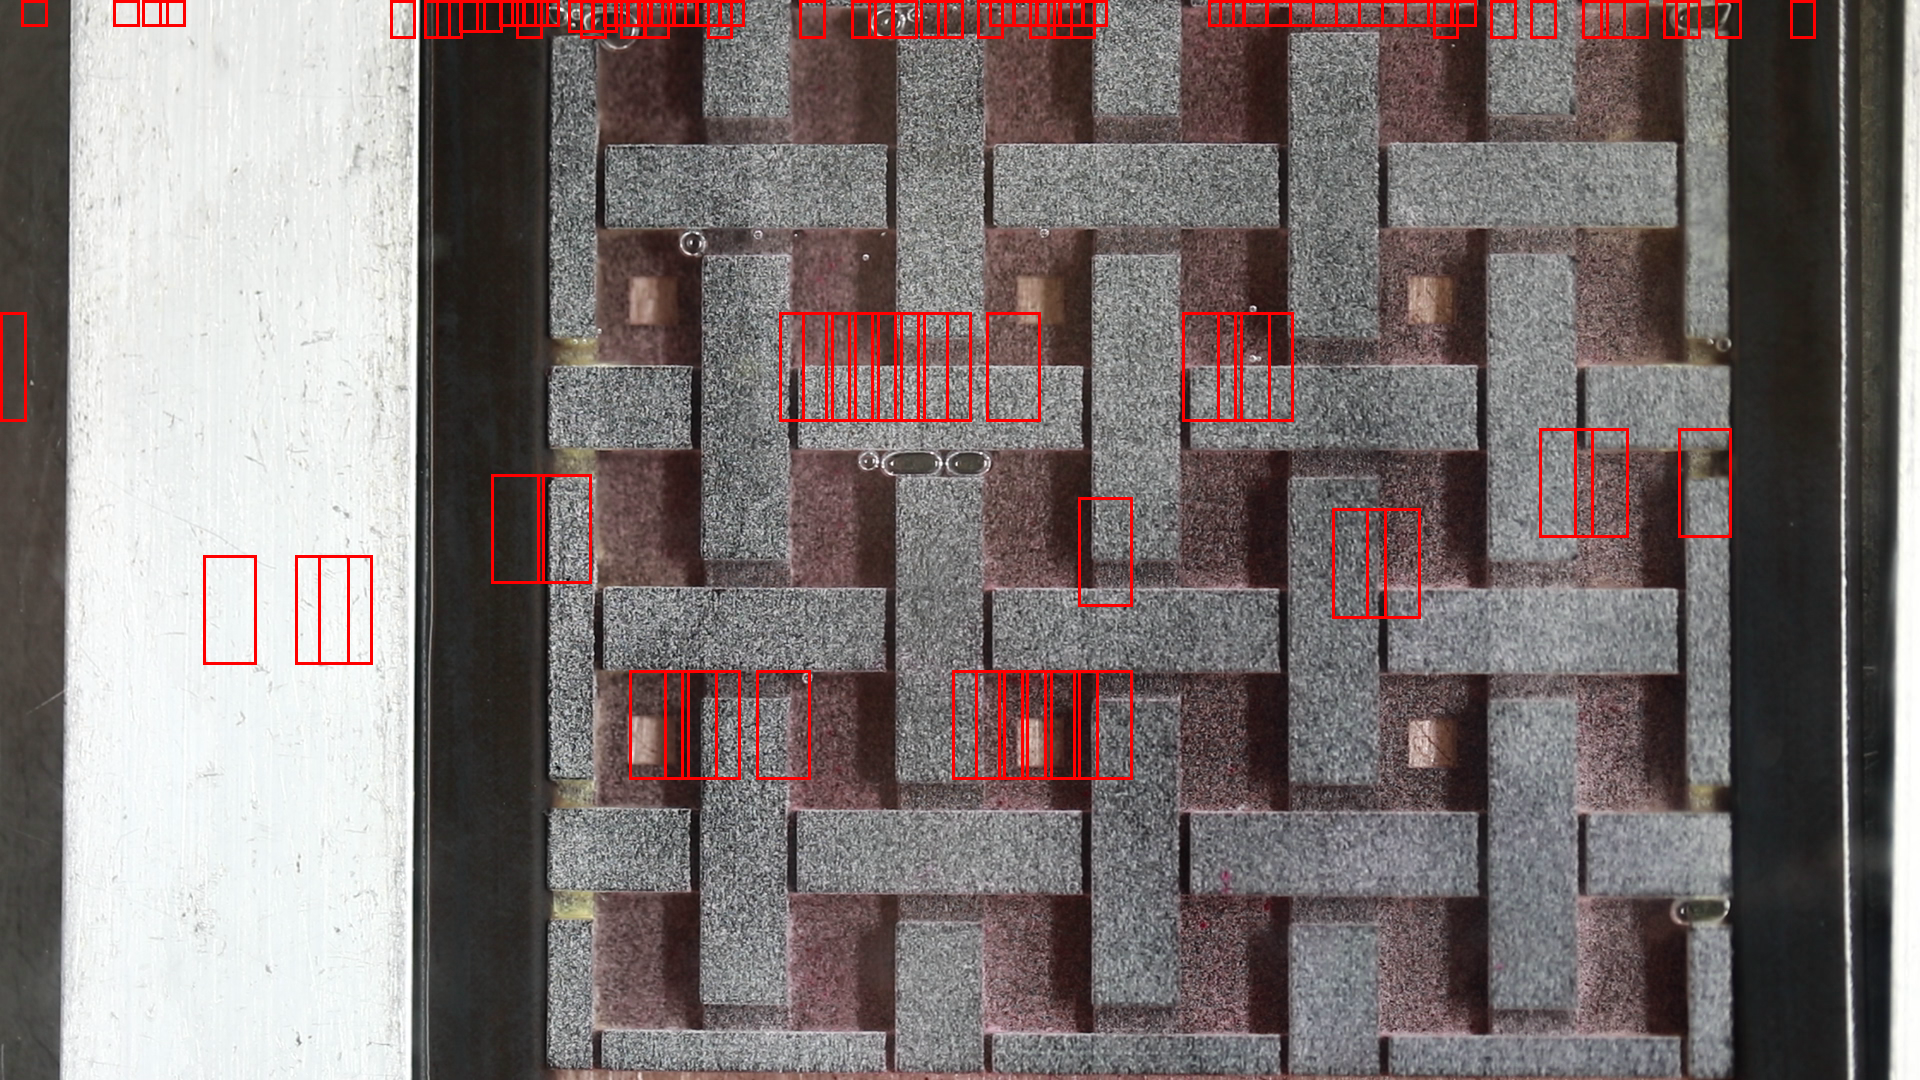

In [93]:
show_results(img,preds[0])